# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [ ]:
!pip install git+https://github.com/openai/baselines.git


In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack
from tensorflow import keras
from tensorflow.keras import layers

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
FRAME_STACK_SIZE = 3
env = gym.make("Asterix-v0")
env = NoopResetEnv(env, noop_max=30)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)
env = FrameStack(env, FRAME_STACK_SIZE)
env.seed(SEED_VALUE)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\program files\python38\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [2]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(84, 84, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


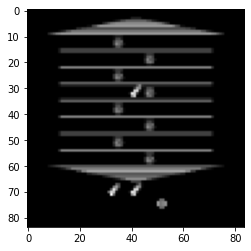

In [3]:
obs = env.reset()
from skimage.color import rgb2gray

# def preprocess_observation(observation):
#     img = observation[23:153:2, ::2] # This becomes 90, 80, 3
# #     print(img.shape)
# #     print(img.shape)
# #     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
#     img = rgb2gray(img)
#     img = img.astype(np.float32) # normalize from -128 to 127
#     return img.reshape(65, 80)


plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    # Release the global state to avoid clutter
    # when creating models (in loops etc.)
#     K.clear_session()
    
    # Reset the Tensorflow graph
#     tf.compat.v1.reset_default_graph()
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

In [5]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
MEMORY_SIZE = 25000
MIN_REPLAY_SIZE = 20000
LEARNING_RATE = 0.00025

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [6]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [7]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [8]:
from collections import deque
import math

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = - math.log(0.01) / MIN_REPLAY_SIZE  # speed of decay

class QLearningAgent():
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step)
        if step <= MIN_REPLAY_SIZE or np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
            return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        
        no_state = np.zeros(INPUT_SHAPE)
        
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
    
        prev_q_vals = self.online.predict(prev_states)
        next_q_vals = self.target.predict(next_states)
        
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value
            future_q_val = q_val
            
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + np.amax(next_q_vals[idx]) * self.discount_rate
            
            X[idx] = curr_state
            Y[idx] = future_q_val
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done):
        
        sample = (curr_state, action, reward, next_state, done)
        X, Y, errors = self.get_train_data([(0, sample)])
        self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value
        """
        
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        if step <= MIN_REPLAY_SIZE:
            return
        
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        state = np.array(env.reset())
        total_reward = 0
#         state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_state, reward, done, info = env.step(action)

    next_state = np.array(next_state)
    
#     next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step % train_online_steps == 0:
        agent.train(step)

    # Regularly copy the online DQN to the target DQN
    if step % update_target_steps == 0:
        agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan


c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 278/1000000 (0.03%)	Loss:   inf	AVG reward: 33	Total mean: 100.0
	Action step: 629/1000000 (0.06%)	Loss:   inf	AVG reward: 100	Total mean: 200.0
	Action step: 921/1000000 (0.09%)	Loss:   inf	AVG reward: 116	Total mean: 250.0
	Action step: 1513/1000000 (0.15%)	Loss:   inf	AVG reward: 200	Total mean: 337.5
	Action step: 1821/1000000 (0.18%)	Loss:   inf	AVG reward: 66	Total mean: 310.0
	Action step: 2427/1000000 (0.24%)	Loss:   inf	AVG reward: 283	Total mean: 400.0
	Action step: 2707/1000000 (0.27%)	Loss:   inf	AVG reward: 33	Total mean: 357.14285714285717
	Action step: 3154/1000000 (0.32%)	Loss:   inf	AVG reward: 100	Total mean: 350.0
	Action step: 3424/1000000 (0.34%)	Loss:   inf	AVG reward: 33	Total mean: 322.22222222222223
	Action step: 3774/1000000 (0.38%)	Loss:   inf	AVG reward: 116	Total mean: 325.0
	Action step: 4092/1000000 (0.41%)	Loss:   inf	AVG reward: 66	Total mean: 313.6363636363636
	Action step: 4600/1000000 (0.46%)	Loss:   inf	AVG reward: 150	Total mean: 325.

In [ ]:
print(ep_rewards)

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [ ]:
np.stack([1,2,3]).reshape(3,1)

In [ ]:
import pandas as pd
x = pd.DataFrame(data=ep_rewards)

In [ ]:


plt.rcParams['figure.figsize']= (20,6)
plt.plot(ep_rewards)
plt.show()

In [ ]:
x['sum'].plot()

In [ ]:
x.to_csv('model_300.csv')